In [1]:
import mysql.connector
import pandas as pd

conn = mysql.connector.connect(
    host='database-1.c3ieyo8m4v9o.ap-northeast-2.rds.amazonaws.com',
    port=3306,
    user='eda_team',
    password='****',
    database='eda_project'
)
cur = conn.cursor()
cursor = conn.cursor(dictionary = True)

cursor.execute("select * from gas_car")
result = cursor.fetchall()

gas_car = pd.DataFrame(result)
conn.close()

In [2]:
import mysql.connector
import pandas as pd

conn = mysql.connector.connect(
    host='database-1.c3ieyo8m4v9o.ap-northeast-2.rds.amazonaws.com',
    port=3306,
    user='eda_team',
    password='****',
    database='eda_project'
)
cur = conn.cursor()
cursor = conn.cursor(dictionary = True)

cursor.execute("select * from gas_distance")
result = cursor.fetchall()

gas_dis = pd.DataFrame(result)
conn.close()

In [3]:
import mysql.connector
import pandas as pd

conn = mysql.connector.connect(
    host='database-1.c3ieyo8m4v9o.ap-northeast-2.rds.amazonaws.com',
    port=3306,
    user='eda_team',
    password='****',
    database='eda_project'
)
cur = conn.cursor()
cursor = conn.cursor(dictionary = True)

cursor.execute("select * from gas_pollution")
result = cursor.fetchall()

gas_poll = pd.DataFrame(result)
conn.close()

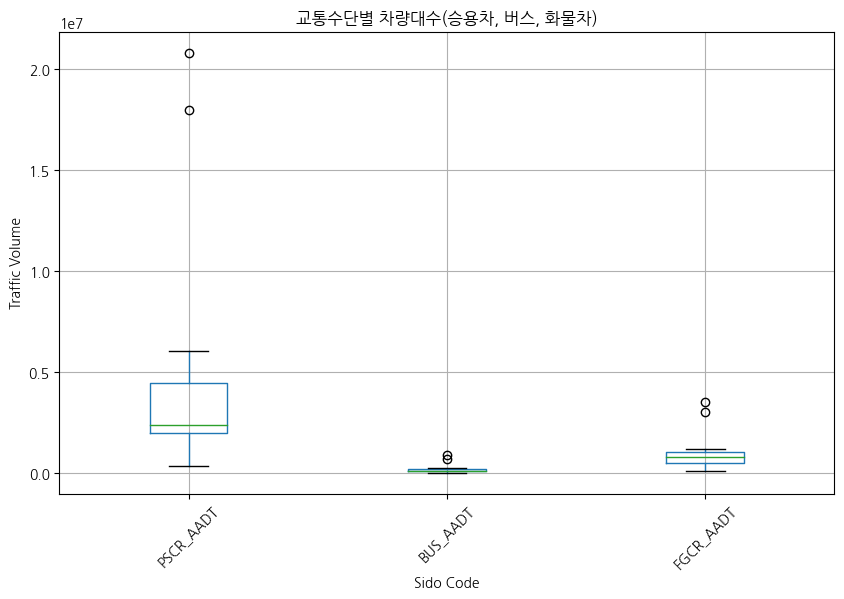

In [5]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

plt.figure(figsize=(10, 6))
gas_car.groupby('sido_code')[['PSCR_AADT', 'BUS_AADT', 'FGCR_AADT']].sum().boxplot()
plt.title('교통수단별 차량대수(승용차, 버스, 화물차)')
plt.ylabel('Traffic Volume')
plt.xlabel('Sido Code')
plt.xticks(rotation=45) 
plt.show()

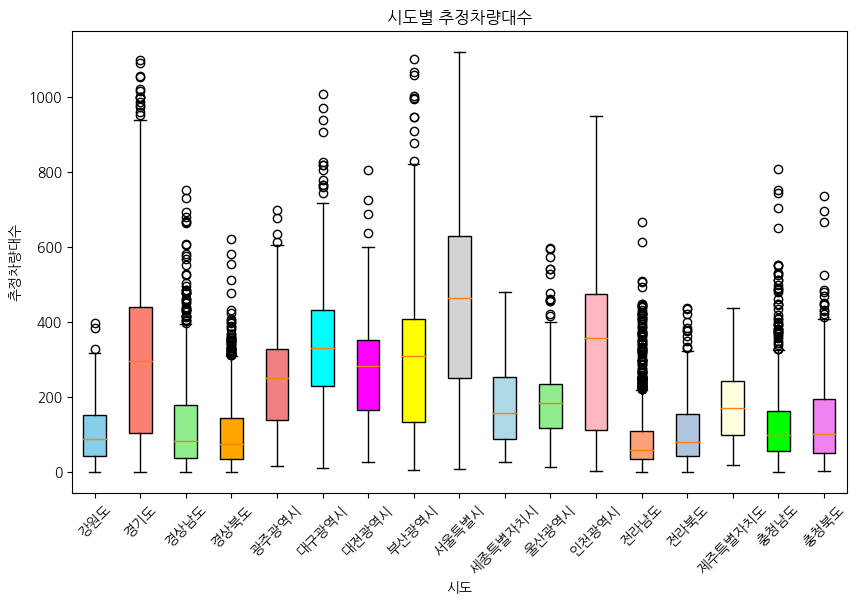

In [6]:
filtered_data = gas_car[gas_car['BUS_AADT'] < gas_car['BUS_AADT'].quantile(0.99)]
grouped_data_filtered = [group['BUS_AADT'].tolist() for name, group in filtered_data.groupby('sido_code')]
plt.figure(figsize=(10, 6))
bp = plt.boxplot(grouped_data_filtered, patch_artist=True)

colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'lightcoral', 'cyan', 'magenta', 'yellow', 'lightgrey', 'lightblue', 'lightgreen', 'lightpink', 'lightsalmon', 'lightsteelblue', 'lightyellow', 'lime', 'violet']

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.title('시도별 추정차량대수')
plt.ylabel('추정차량대수')
plt.xlabel('시도')
plt.xticks(range(1, len(grouped_data_filtered) + 1), sorted(filtered_data['sido_code'].unique()))
plt.xticks(rotation=45)
plt.show()

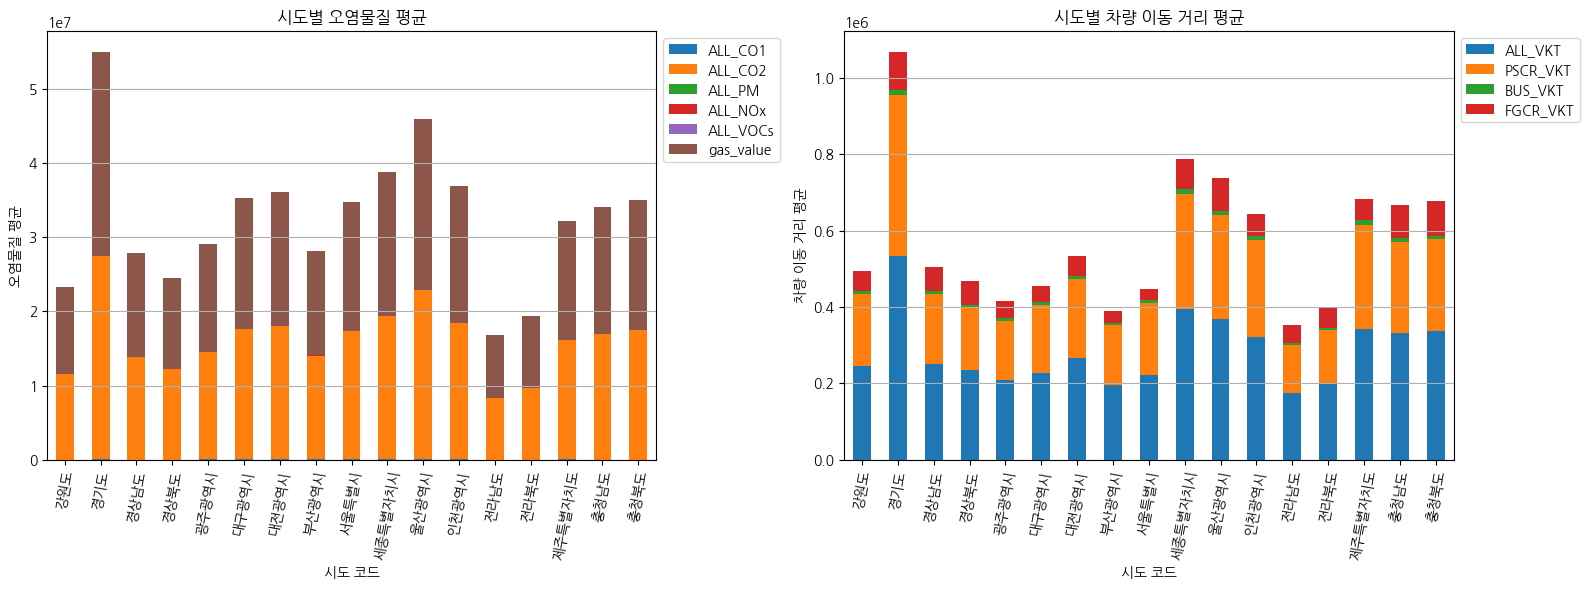

In [7]:
import matplotlib.pyplot as plt

pollutants_sum_by_sido = gas_poll.groupby('sido_code')[['ALL_CO1', 'ALL_CO2', 'ALL_PM', 'ALL_NOx', 'ALL_VOCs', 'gas_value']].mean()
distance_sum_by_sido = gas_dis.groupby('sido_code')[['ALL_VKT', 'PSCR_VKT', 'BUS_VKT', 'FGCR_VKT']].mean()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

pollutants_sum_by_sido.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('시도별 오염물질 평균')
axes[0].set_xlabel('시도 코드')
axes[0].set_ylabel('오염물질 평균')
axes[0].set_xticklabels(pollutants_sum_by_sido.index, rotation=80)
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[0].grid(axis='y')

distance_sum_by_sido.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('시도별 차량 이동 거리 평균')
axes[1].set_xlabel('시도 코드')
axes[1].set_ylabel('차량 이동 거리 평균')
axes[1].set_xticklabels(distance_sum_by_sido.index, rotation=80)
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

In [8]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(distance_sum_by_sido.sum(axis=1), pollutants_sum_by_sido.sum(axis=1))
print("피어슨 상관계수:", correlation)

피어슨 상관계수: 0.8540076405847953


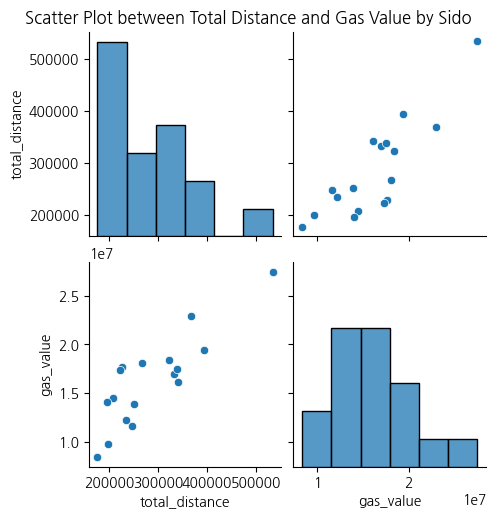

In [9]:
import seaborn as sns

merged_df = pd.merge(distance_sum_by_sido, pollutants_sum_by_sido, on='sido_code')
merged_df = merged_df.rename(columns={'ALL_VKT': 'total_distance'})

sns.pairplot(merged_df, vars=['total_distance', 'gas_value'], kind='scatter')
plt.suptitle('Scatter Plot between Total Distance and Gas Value by Sido', y=1.02)
plt.show()

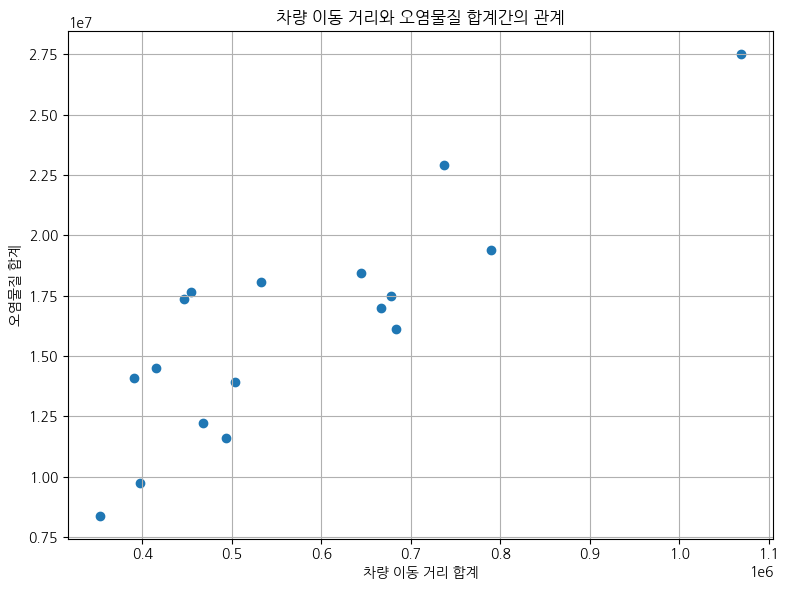

In [10]:
pollutants_sum_by_sido = gas_poll.groupby('sido_code')[['ALL_CO1', 'ALL_CO2', 'ALL_PM', 'ALL_NOx', 'ALL_VOCs', 'gas_value']].mean()
distance_sum_by_sido = gas_dis.groupby('sido_code')[['ALL_VKT', 'PSCR_VKT', 'BUS_VKT', 'FGCR_VKT']].mean()

plt.figure(figsize=(8, 6))
plt.scatter(distance_sum_by_sido.sum(axis=1), pollutants_sum_by_sido['gas_value'])
plt.title('차량 이동 거리와 오염물질 합계간의 관계')
plt.xlabel('차량 이동 거리 합계')
plt.ylabel('오염물질 합계')
plt.grid(True)
plt.tight_layout()
plt.show()

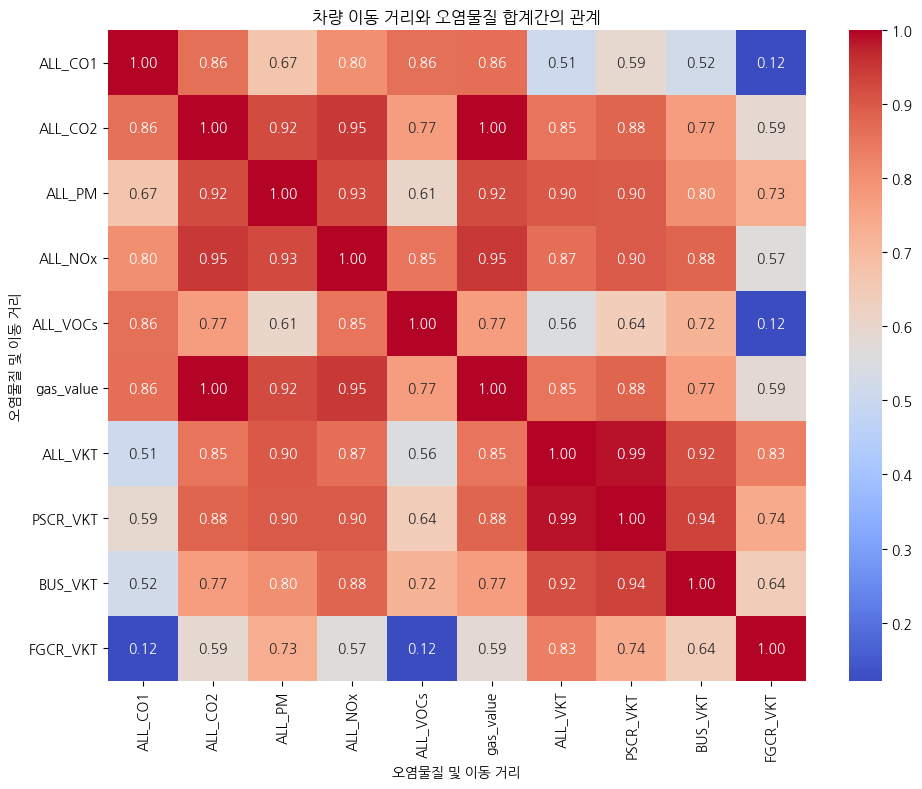

In [11]:
merged_data = pollutants_sum_by_sido.join(distance_sum_by_sido)

plt.figure(figsize=(10, 8))
sns.heatmap(merged_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('차량 이동 거리와 오염물질 합계간의 관계')
plt.xlabel('오염물질 및 이동 거리')
plt.ylabel('오염물질 및 이동 거리')
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

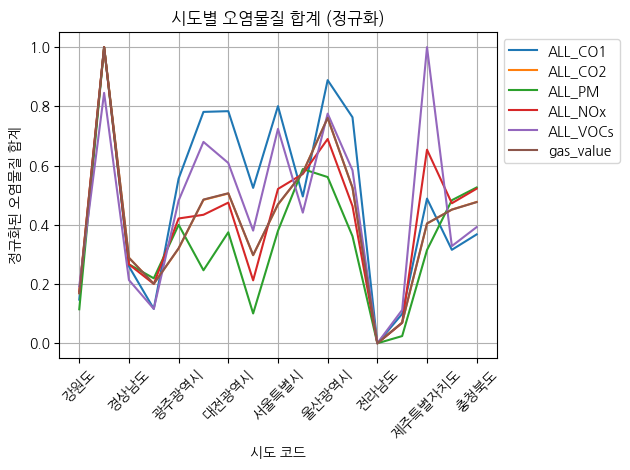

In [12]:
from sklearn.preprocessing import MinMaxScaler

pollutants_sum_by_sido_excluded_2018 = pollutants_sum_by_sido[pollutants_sum_by_sido.index != 2018]
scaler = MinMaxScaler()

pollutants_sum_by_sido_normalized_excluded_2018 = pd.DataFrame(scaler.fit_transform(pollutants_sum_by_sido_excluded_2018), columns=pollutants_sum_by_sido_excluded_2018.columns, index=pollutants_sum_by_sido_excluded_2018.index)

plt.figure(figsize=(14, 8))
pollutants_sum_by_sido_normalized_excluded_2018.plot(kind='line')
plt.title('시도별 오염물질 합계 (정규화)')
plt.xlabel('시도 코드')
plt.ylabel('정규화된 오염물질 합계')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()